In [1]:
import openmc
import openmc.deplete
import numpy as np
import scipy.linalg as sla
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import matplotlib as mpl
params = {'image.aspect':'equal',
          'savefig.dpi':600,
          'axes.grid':True,
          'axes.grid.which':"both",
          'font.size':12,
          'text.usetex':True,
          'text.color':'black',
          'image.cmap':'viridis'}
mpl.rcParams.update(params)

Volume = 48710000.0 #cm
openmc.config['chain_file'] = "chain_endfb71_pwr.xml"

In [2]:
results = openmc.deplete.Results("results/depletion_results.h5")

In [7]:
poisons = ["Xe135", "Sm149"]
actinides = ["Th233", "Pa233", "Pa234", "U234", "U235"]
heaters = ["Sr90", "Kr85", "Cs137"]
specific_nuclides = poisons + actinides + heaters

noble_metals = ["Ru","Rh","Pd","Ag", "Os", "Ir", "Pt", "Au"]
simp_nm = ["Ru","Rh","Pd","Ag"]
lanthanides = ["Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]
tru = ["Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr"]

gases = ["Xe", "Kr", "I"]


targs_of_interest = specific_nuclides + noble_metals + tru + lanthanides + gases + ["U"]

def get_element(elem):
    t, r = results.get_atoms("1","He4")
    output = np.zeros_like(r)
    valid_nucs = []
    for i in range(250):
        try:
            _, out = results.get_atoms("1", elem + str(i), "atoms")
            output += out
            valid_nucs.append(elem+str(i))
        except:
            pass
    return t, interp.interp1d(t, output/Volume, 3)

my_concs = {}
for target in targs_of_interest:
    t, interpolator = get_element(target)
    my_concs[target] = interpolator
for target in specific_nuclides:
    t, num = results.get_atoms("1", target)
    my_concs[target] = interp.interp1d(t, num / Volume)
time = t

def get_heat_d(elems):
    time, heat = results.get_decay_heat("1",by_nuclide=True)
    d = {}
    for elem in elems:
        d[elem] = get_heat(elem)[1]
    for target in specific_nuclides:
        out = np.zeros_like(time)
        for i in range(len(heat)):
            out[i] = heat[i][target]
        d[target] = interp.interp1d(t, out, 3)
        print(out)
    d["total"] = interp.interp1d(t, results.get_decay_heat("1")[1], 3)
    return d
    
def get_heat(elem):
    output = np.zeros_like(time)
    for i in range(250):
        try:
            for j in range(len(time)):
                output[j] += heat[j][elem + str(i)]
        except:
            pass
    return t, interp.interp1d(t, output, 3)

decay_heat = get_heat_d(targs_of_interest)
    
   
def plot_conc(elems, show = 1, name = None):
    fig, ax = plt.subplots()
    for targ in elems:
        ax.semilogy(time, my_concs[targ](time), label = targ)
        ax.legend(bbox_to_anchor=(1.0-0.015, 1.0225))
    ax.set_ylabel("Number Density\quad [at $\cdot$ cm$^{-3}$]")
    ax.set_xlabel("Time\quad [s]")
    ax.set_xlim(time[0],time[-1])
    plt.tight_layout()
    if name:
        fig.savefig("plots/" + name + ".png", dpi = 600, bbox_inches='tight')
    if show:
        plt.show()

def plot_heat(elems, show = 1, name = None):
    fig, ax = plt.subplots()
    for targ in elems:
        ax.semilogy(time, decay_heat[targ](time), label = targ)
        ax.legend(bbox_to_anchor=(1.0-0.015, 1.0225))
    ax.set_ylabel("Decay Heat\quad [W]")
    ax.set_xlabel("Time\quad [s]")
    ax.set_xlim(time[0],time[-1])
    plt.tight_layout()
    if name:
        fig.savefig("plots/" + name + ".png", dpi = 600, bbox_inches='tight')
    if show:
        plt.show()

[  0.           2.61768931   5.27769565   7.98058327  10.72645325
  13.51511686  16.34659514  19.22092623  22.13776271  25.09673856
  28.09778778  31.1408532   34.22543986  37.35131256  40.51831786
  43.72639463  46.97494819  50.26404643  53.59297994  56.96206698
  60.37069762  63.81850505  67.3058519   70.83191991  74.39665586
  77.99965721  81.64088941  85.31997642  89.03700742  92.79165899
  96.58350291 100.41226862 104.27787987 108.18008831 112.11857353
 116.0933606  120.10407919 124.15045446 128.23241357 132.34966796
 136.5019703  140.6890481  144.91074955 149.16703785 153.45742938
 157.78183706 162.14005377 166.53200922 170.95742599 175.41599842
 179.90766692 184.43205939 188.98920409 193.57860092 198.20033615
 202.85411231 207.53967854 212.25693358 217.00594269 221.78623713
 226.59733331]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[     

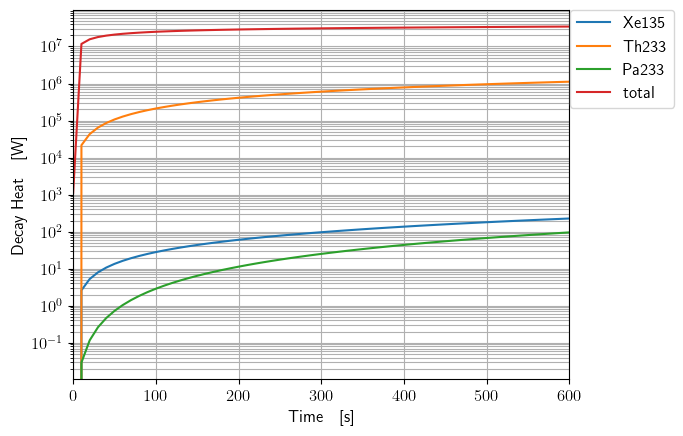

In [6]:
# checkers
fig, ax = plt.subplots()
for targ, func in decay_heat.items():
    y_vals = func(time)
    if sla.norm(y_vals) > 1:
        ax.semilogy(time, y_vals, label = targ)
ax.legend(bbox_to_anchor=(1.0-0.015, 1.0225))
ax.set_ylabel("Decay Heat\quad [W]")
ax.set_xlabel("Time\quad [s]")
ax.set_xlim(time[0],time[-1])
fig.savefig("plots/" + "total_heat" + ".png", dpi = 600, bbox_inches='tight')

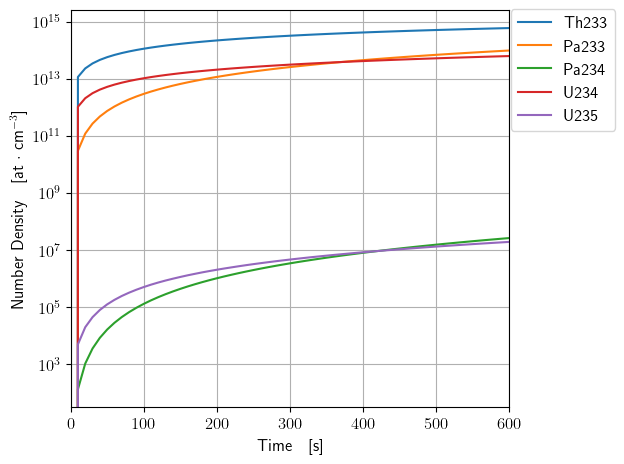

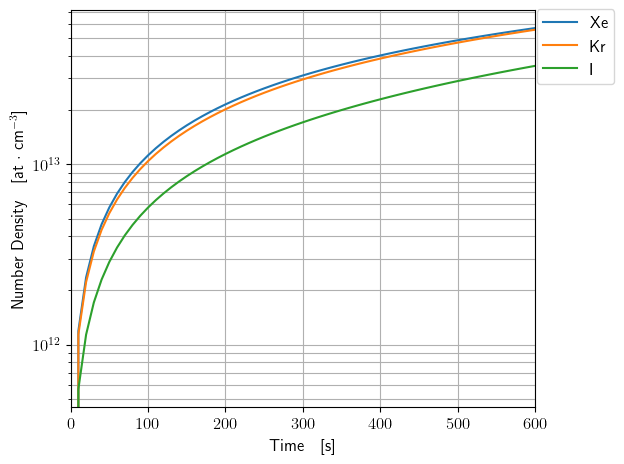

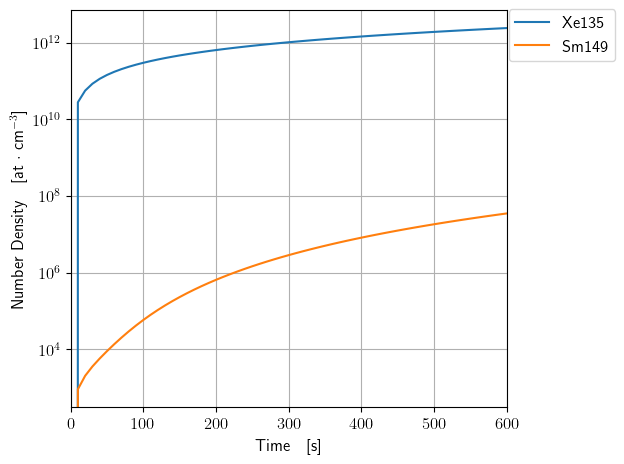

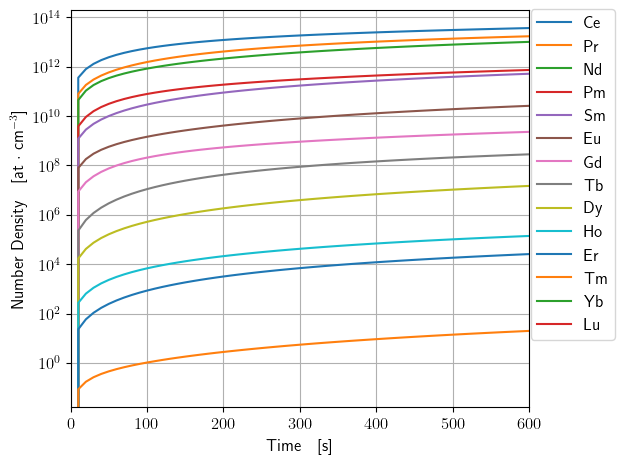

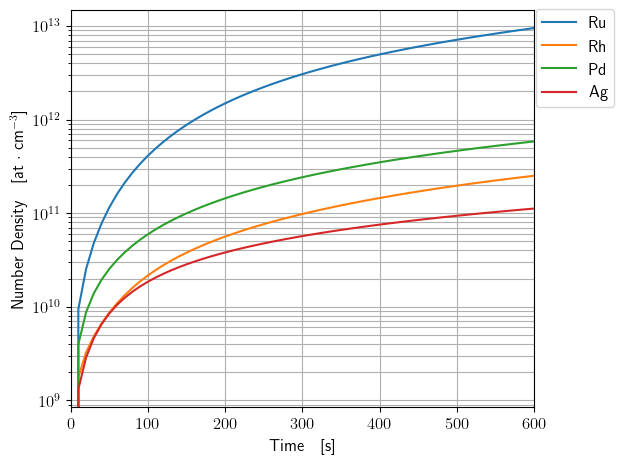

/var/folders/d4/pdxfd7q52q5bx7ygq94q2ytc0000gn/T/ipykernel_85515/3830732223.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(time[0],time[-1])


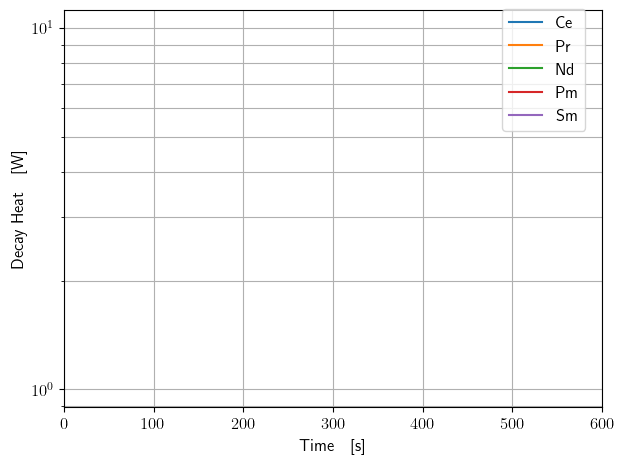

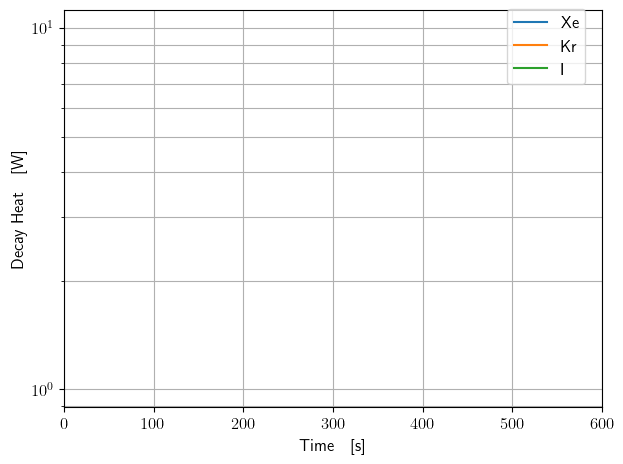

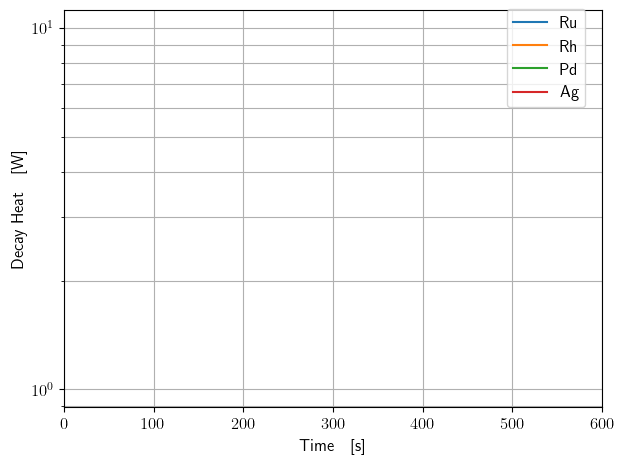

In [8]:
# Real plots
plot_conc(actinides, name = "actinide_concs")
plot_conc(gases, name = "gas_concs")
plot_conc(poisons, name = "poison_concs")
plot_conc(lanthanides, name = "lanth_concs")
plot_conc(simp_nm, name = "nm_concs")

plot_heat(["Ce", "Pr", "Nd", "Pm", "Sm"], name="lanth_heat")
plot_heat(gases, name = "gas_heat")
plot_heat(simp_nm, name = "nm_heat")